<a href="https://colab.research.google.com/github/marongkang/MLeveryday/blob/main/MLEveryday9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Random Forest 随机森林
**概述**  
*  目标: 给出一些数据，选择特征并且决定以什么样的方式分裂数据来做出预测。
* 优点:
 *  决策树可以做成分类树和回归树。
 *  具有很强的可解释性。
 *  仅需很少的数据预处理。
 *  受离群数据(outlier)的影响小
 *  不易过拟合(overfit)
 *  处理高维数据速度快
*  缺点:
 *  当训练数据少于分类类别的时候表现很差（下限高，上限低）。
*  其他:
 *  一组决策树可以构成随机森林，预测结果也会由所有的决策树所决定。

#训练  
步骤  
1. 基于每一个特征进行分割(例如. 根据三个特征来判断结果是yes还是no）
2. 计算每个特征分裂时候的损失。一些热门的算法比如使用Gini系数来计算的CART算法，还有使用熵和信息增益来计算的ID3。它们都基本上测量了预测值中的杂质或者无序。

* $H(X)=∑_{c∈C}−p(c)log_2p(c)$  
* where:
 * H(X): 数据集X的熵
 * C: 类别集合
 * p(c): 在c类别中和所有实例的占比  
对于一个二分类任务来说，如果所有的样例在一个类别下都是相同的，那么它的熵值为0，如果仅有一半是正确的，那么它的熵值则为1（也是最差的情况等同于瞎猜）。一旦我们决定了熵值，我们需要计算出信息增益(IG)(比如. 在我们把数据X基于特征F分裂后不确定的样本减少了多少)。

* $IG(F,X)=H(S)−∑_{t∈T}p(t)H(t)$
* where:
 * IG(F. X): 数据X基于特征F分裂后的信息增益
 * H(X): 数据集X的熵
 * T: 基于分裂F后的子集
 * p(t): 所有实例中t的实例数的比例
 * H(t): 子集t的熵 

**注意**: 对于回归问题，你可以用标准偏差（standard deviation）来取代信息增益。

3. 在所有的特征分裂后，信息增益最高的分裂将作为第一个特征的分裂(也就是决策树的根).

4. 基于第一次分裂后，重复上述的步骤在余下的所有特征中。最后，我们将分裂到叶子结点，在叶子结点中大部分样本将会来自同一类。

#数据  
titanic.csv

In [ ]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

args=Namespace(
    seed=1234,
    data_file="titanic.csv",
    train_size=0.75,
    test_size=0.25,
    num_epochs=100,
    max_depth=4,
    min_samples_leaf=5,
    n_estimators=10,
)
np.random.seed(args.seed)

In [ ]:
#老方法导入Titanic.csv,生成dataframe
import urllib.request
url="https://raw.githubusercontent.com/marongkang/datasets/main/titanic.csv"
response=urllib.request.urlopen(url)
html=response.read()
f=open(args.data_file,'wb')
f.write(html)
df=pd.read_csv(args.data_file,header=0)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def preprocess(df):
  df=df.dropna() #删除NaN

  #删除基于文本的feature
  features_to_drop=["Name","Cabin","Ticket","PassengerId"]
  df=df.drop(features_to_drop,axis=1)

  #pclass,sex,embarked 映射为数
  df["Sex"]=df["Sex"].map({"female":0,"male":1}).astype(int)
  df["Embarked"]=df["Embarked"].dropna().map({"S":0,"C":1,"Q":2}).astype(int)

  return df

In [ ]:
df=preprocess(df)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,1,0,38.0,1,0,71.2833,1
3,1,1,0,35.0,1,0,53.1000,0
6,0,1,1,54.0,0,0,51.8625,0
10,1,3,0,4.0,1,1,16.7000,0
11,1,1,0,58.0,0,0,26.5500,0


In [ ]:
#划分数据
mask=np.random.rand(len(df))<args.train_size
#print(mask,type(mask))
train_df=df[mask]
test_df=df[~mask] #~按位取反
print("Train size: {0}, Test size: {1}".format(len(train_df),len(test_df)))
train_df.head()

Train size: 131, Test size: 52


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,1,0,38.0,1,0,71.2833,1
3,1,1,0,35.0,1,0,53.1000,0
6,0,1,1,54.0,0,0,51.8625,0
21,1,2,1,34.0,0,0,13.0000,0
23,1,1,1,28.0,0,0,35.5000,0


In [ ]:
#分离X，Y
X_train=train_df.drop(["Survived"],axis=1)
y_train=train_df["Survived"]
X_test=test_df.drop(["Survived"],axis=1)
y_test=test_df["Survived"]

In [ ]:
dtree=DecisionTreeClassifier(criterion="entropy",random_state=args.seed,
              max_depth=args.max_depth,
              min_samples_leaf=args.min_samples_leaf)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5,
                       random_state=1234)

In [ ]:
pred_train=dtree.predict(X_train)
pred_test=dtree.predict(X_test)

In [ ]:
#正确率
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
train_acc =accuracy_score(y_train,pred_train)
test_acc =accuracy_score(y_test,pred_test)
print("train accuracy: {0:.3f},test accuracy: {1:.3f}".format(train_acc,test_acc))

train accuracy: 0.863,test accuracy: 0.712


使用sklearn建立random tree已经完成，接下来是操作的可视化
#可解释性

In [ ]:
#安装必要的包
#!apt-get install graphviz
#!pip install pydotplus

In [ ]:
#from sklearn.externals.conftest import StringIO 此包已删除，现使用以下方法
#!pip install six
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

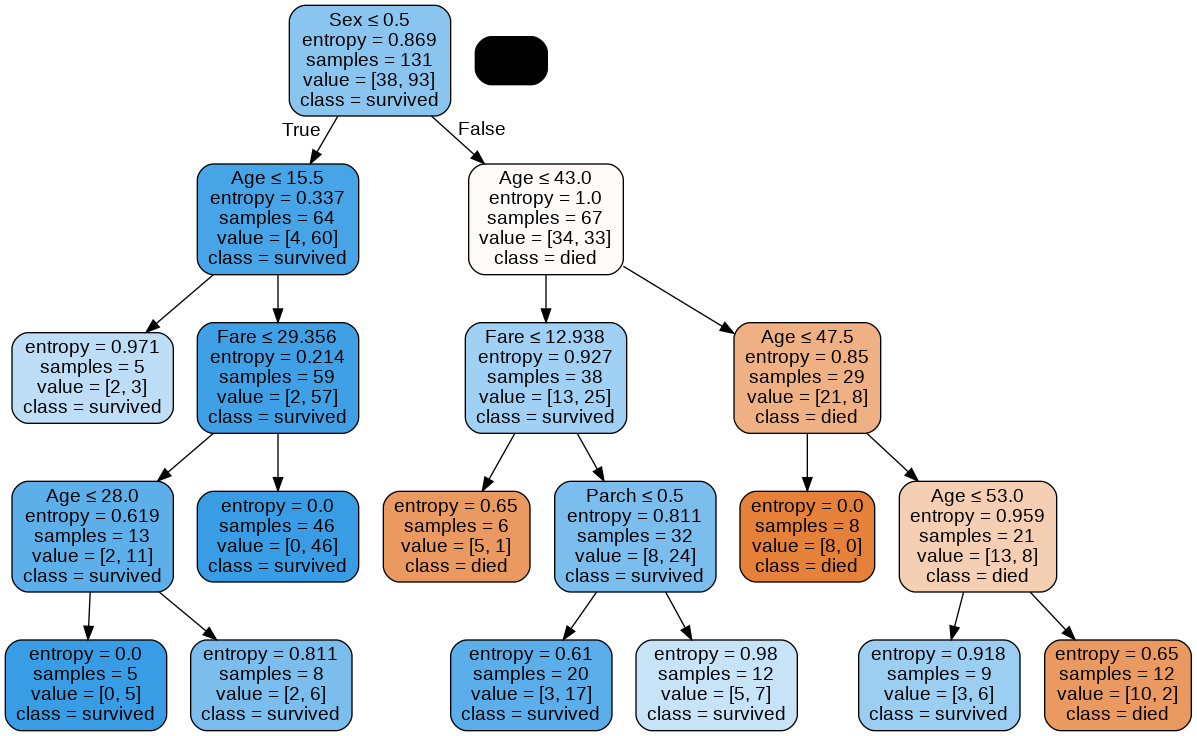

In [ ]:
#可解释性
dot_data=StringIO()
export_graphviz(dtree,out_file=dot_data,
        feature_names=list(train_df.drop(["Survived"],axis=1)),
        class_names=["died","survived"],
        rounded=True,filled=True,special_characters=True)
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png(),width=500,height=300)

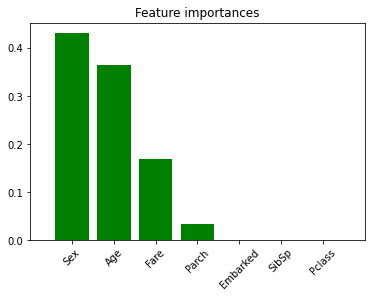

Sex:0.431
Age:0.365
Fare:0.169
Parch:0.0343
Embarked:0.0
SibSp:0.0
Pclass:0.0


In [ ]:
#特征重要性
features=list(X_test.columns)
importances=dtree.feature_importances_
indices=np.argsort(importances)[::-1]
num_features=len(importances)

#画图
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features),importances[indices],color="g",align="center")
plt.xticks(range(num_features),[features[i] for i in indices],rotation='45')
plt.xlim([-1,num_features])
plt.show()

for i in indices:
  print("{0}:{1:.3}".format(features[i],importances[i]))

#Random forest随机森林
随机森林由一组，或者说一个集成的决策树在一起构建，与单个决策树相比，一组不同的树将产生更准确的预测。随机森林中的不同决策树由不同的数据子集，甚至不同的特征阈值组成，以保证每棵树都是不同的  


**Scikit-learn实现**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#initialize
forest=RandomForestClassifier(
    n_estimators=args.n_estimators,criterion="entropy",
    max_depth=args.max_depth,min_samples_leaf=args.min_samples_leaf)
#train
forest.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5,
                       n_estimators=10)

In [ ]:
#predicate
RF_pred_train=forest.predict(X_train)
RF_pred_test=forest.predict(X_test)
#accuracy
RF_train_acc=accuracy_score(y_train,RF_pred_train)
RF_test_acc=accuracy_score(y_test,RF_pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(RF_train_acc, RF_test_acc))

precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

train acc: 0.84, test acc: 0.71
precision: 0.68. recall: 0.93, F1: 0.79


#可解释性

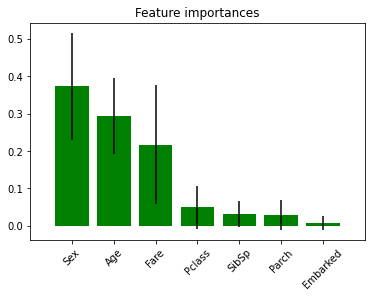

In [ ]:
#feature importances
features=list(X_test.columns)
importances=forest.feature_importances_
std=np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices=np.argsort(importances)[::-1]
num_features=len(importances)

#draw
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], yerr=std[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1,num_features])
plt.show()